<div style='background-image: url("main.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px ; width: 100%'>
    <div style="float: right ; margin: 20px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , .8) ; line-height: 100%">Physique des ondes
            </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Paquet d'onde | Paquet d'onde & milieu dispersif
             </div>
        </div>
    </div>
</div>

<b>*ATTENTION!*
Les calculs engagés dans ce notebook sont longs et ne peuvent être raccourcis qu'au prix d'une erreur numérique parfois conséquente. Une exécution pas à pas est recommandée.</b>

&nbsp;
<b>De même, les valeurs par défaut des diverses grandeurs `Num_x`, `L`, `lambda0` etc.. sont le fruit de nombreux tests. Vous vous éloignerez de ces valeurs *à vos risques et périls (numériques)*... </b>

In [1]:
# commande permettant d'insérer les figures matplotlib dans les notebooks
%matplotlib widget

# import des librairies 
import numpy as np
from scipy.integrate import odeint
from scipy import fft
import matplotlib.pyplot as plt

# Mise en œuvre du problème physique
##  Propagation d'une onde électromagnétique

On étudie la propogation d'une onde électromagnétique dans le divers milieux en commençant par le plus simple : le vide.

&nbsp;
Le domaine étudié à une longueur de $L=50~\text{m}$, la longueur d'onde choisie est $\lambda_0=1~\text{m}$, et, pour rendre plus lisibles les résultats, on fixera la célérité des ondes dans le vide à $c=1~\text{m.s}^{-1}$. On en déduit la valeur de la pulsation associée dans le vide, noté $\omega_0$.

In [2]:
# Domaine de calcul
L = 50 # longueur

# Signal EMAG
E_amp = 1 # amplitude
lambda0 = 1 # longueur d'onde
sigma0 = 1 / lambda0 # nombre d'onde
c = 1 # célérité 
omega0=2*np.pi*sigma0*c # pulsation associée à la longueur d'onde

## Variables numériques
Les variables numériques spatiales, nombre de points et pas d'espace sont `Num_x` et `delta_x`, tandis que les variables temporelles sont `Num_t` et `delta_t`.

In [3]:
# Intégration spatiale
Num_x = 5001 # points de calcul
x=np.linspace(0,L,Num_x) # vecteur position
delta_x = x[1]-x[0] # intervalle spatial d'intégration


# Intégration temporelle
Num_t = 10001 # points de calcul
t=np.linspace(0,L/(c),Num_t) # vecteur temps
delta_t = t[1]-t[0] # intervalle temporel d'intégration

# Propagation d'une onde dans un plasma (milieu dispersif mais non absorbant)

## Forme d'onde simple, fenêtre de Hann
On utilise à nouveau la fonction `Hann`, présentée dans le notebook sur les ondes électromagnétiques dans le vide.

In [4]:
x0=L/2 # position initiale de la forme d'onde

## Fenêtre de définition de la forme d'onde
def Hann(x,x0,H):
    func=np.zeros(len(x))
    for i in range(len(x)):
        if abs(x[i]-x0)<H/2:
            func[i]=.5*(1-np.cos(2*np.pi*(x[i]-x0+H/2)/H))
    return func

## Propagation dans un plasma (milieu non absorbant mais dispersif)
Dans un plasma peu dense, on montre que, même si la densité volumique de charge locale reste nulle, un courant peut néanmoins apparaître qui vérifie : 
$$\dfrac{\partial}{\partial t}\vec{j}=\beta \vec{E}$$
L'équation de propagation est à nouveau modifiée et on a, cette fois : 
$$\dfrac{\partial^2 E}{\partial t^2}=c^2\dfrac{\partial^2 E}{\partial x^2}-\omega_p^2 E$$
où $\omega_p$ est la pulsation propre du plasma.

### Approche numérique
On peut donc reprendre le code de la propagation dans le vide en y ajoutant un terme source $-\omega_p^2 E$.

In [5]:
####################################
### PAQUET D'ONDE DANS UN PLASMA ###
####################################

# Intégration temporelle, replacée ici pour pouvoir modifier à loisir Num_t sans conséquences pour la suite
Num_t = 20001 # points de calcul
t=np.linspace(0,L/(c),Num_t) # vecteur temps
delta_t = t[1]-t[0] # intervalle temporel d'intégration

omega_p = 10

## Forme d'onde à l'instant t, t-dt et t+dt
x0=L/50

E = E_amp*Hann(x,x0,lambda0)*np.cos(2*np.pi*x*4/lambda0)
E_old  = E_amp*Hann(x,x0-c*delta_t,lambda0)*np.cos(2*np.pi*(x+c*delta_t)*4/lambda0)
E_new  = E_amp*Hann(x,x0+c*delta_t,lambda0)*np.cos(2*np.pi*(x-c*delta_t)*4/lambda0)

In [6]:
E_store=[] # liste dans laquelle on stocke quelques formes d'onde intermédiaires
time_store=[] # liste dans laquelle on stocke les instants correspondants

d2Ex=np.zeros(Num_x)

def source(E):
    return -(omega_p**2)*E

duree, k, time = 45, 0,0.
while time < duree : 
    for i in range(Num_x-1):
        if i==0 :
            d2Ex[i] = (E[i+1]+0-2*E[i])/delta_x**2
        elif i==1 or i==Num_x-2 :
            d2Ex[i] = (E[i+1]+E[i-1]-2*E[i])/delta_x**2
        elif i==Num_x-1:
            d2Ex[i] = (0+E[i-1]-2*E[i])/delta_x**2
        else :
            d2Ex[i] = (-1/12*E[i+2]+4/3*E[i+1]-5/2*E[i]+4/3*E[i-1]-1/12*E[i-2])/delta_x**2
    E_new = 2*E - E_old + ((c*delta_t)**2)*d2Ex + source(E)*delta_t**2
    E_old, E = E, E_new
    if k%(duree/(5*delta_t)) == 0 :
        E_store.append(E)
        time_store.append(time)
    k += 1
    time += delta_t

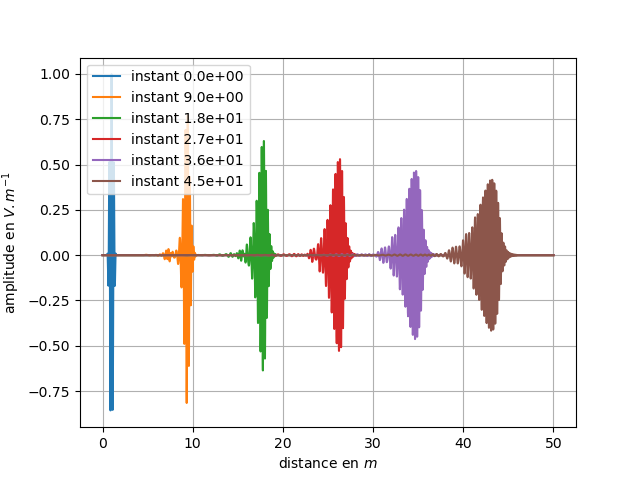

In [7]:
plt.figure()
plt.grid(True)
for i in range(len(E_store)) :
    plt.plot(x,E_store[i], label="instant "+str(format(time_store[i], "#.1e")))
plt.xlabel(r"distance en $m$")
plt.ylabel(r"amplitude en $V.m^{-1}$")
plt.legend()
plt.show()

La forme d'onde semble se déformer au cours de la propagation. Les longueurs d'onde les plus courtes se propagent plus rapidement que les plus longues : on parle d'*étalement du paquet d'onde*.

Pour mettre en évidence ce comportement du plasma, on définit une nouvelle fonction de pondération `milieu(x,x_lim)` qui prend les valeurs suivantes :
$$\left\lbrace\begin{array}{l}
\text{milieu}(0<x<L/2)=0 \\
\text{milieu}(L/2<x<L)=1
\end{array}\right.$$

&nbsp;
Cette fonction de pondération sera appliquée au terme source de l'équation d'onde du plasma, permettant ainsi de définir deux zones : l'une où le milieu est le vide, sans terme source, et l'autre le plasma de pulsation propre $\omega_p$.

### Relation de dispersion du plasma
La relation de dispersion de ce modèle de plasma s'écrit :
$$c^2k^2=\omega^2-\omega_p^2$$

Elle permet de définir deux grandeurs :
* la vitesse de phase $v_\phi=\frac{\omega}{k}$;
* la vitesse de groupe $v_g=$v_g=\frac{\text{d}\omega}{\text{d}k}$;

On montre que la vitesse de groupe vérifie :
$$\left( \dfrac{v_g}{c} \right)^2 = 1-\left(\dfrac{\omega_p}{2\pi c}\right)^2\lambda_0^2<c$$
Alors que la vitesse de phase vérifie : 
$$\left( \dfrac{v_\phi}{c} \right)^2 = \dfrac{1}{1-\left(\dfrac{\omega_p}{2\pi c}\right)^2\lambda_0^2}>c$$

Seule la vitesse de groupe peut être associée à un transport d'énergie ou d'information. Cette vitesse n'est définie que pour $\omega>omega_p$, et reste bien inférieure à $c$.

### Animation
Dans l'animation ci-dessous, on reprend la forme d'onde utilisée dans le métal, c'est à dire avec `H=10*lambda0`, `lambda=lambda0`et on fixe `omega_p=5<omega0`. 

&nbsp;
On vérifie que l'onde se propage bien dans le plasma, et on remarque que, dans ce milieu, la phase avance plus vite que le paquet d'onde.

In [8]:
from IPython.display import Video

Video("prop_plasma_paquet.mp4", width=640)

On peut alors chercher à vérifier la relation proposée ci-dessus.

&nbsp;
Pour cela, il faut fixer la longueur d'onde dans le vide de la forme d'onde initiale, puis essayer de déterminer la vitesse de propagation du paquet d'onde (vitesse de groupe $v_g$) dans les milieux vide et plasma. À cette fin, on relève la position du paquet d'onde à divers instants et on trace cette position en fonction du temps écoulé pour vérifier que la relation est bien affine. Dans ce cas, la pente donne la valeur de la vitesse de groupe de l'onde.

&nbsp;
La méthode mise en place, on recommence plusieurs fois le calcul en faisant varier la longueur d'onde et on stocke les diverses valeurs calculées dans les arrays `c_plasma_num` et `lambda_vide_num`.

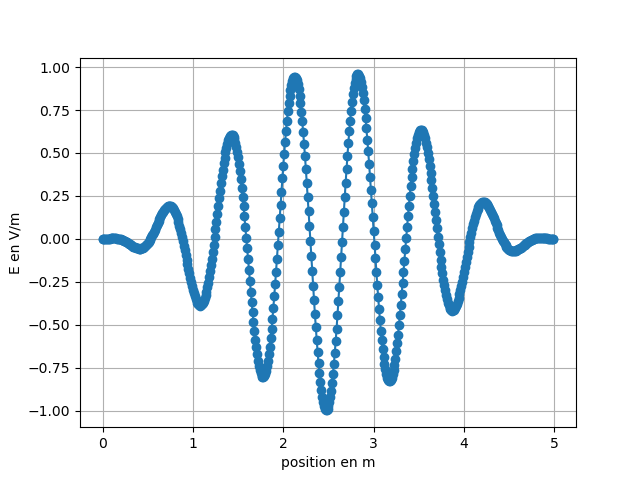

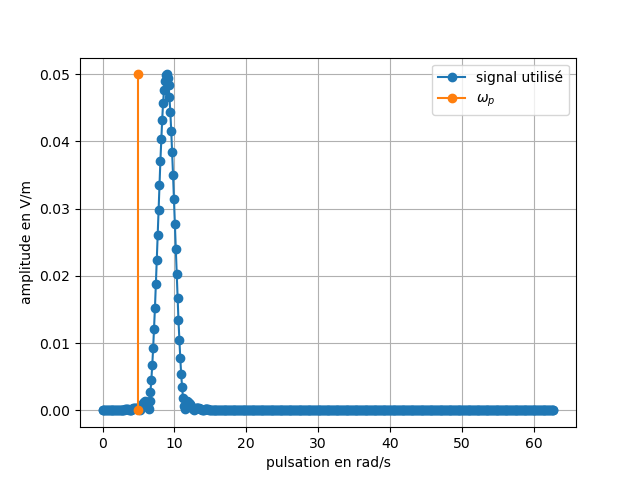

In [9]:
####################################################
### PASSAGE D'UN PAQUET D'ONDE DU VIDE AU PLASMA ###
####################################################

# Intégration temporelle, replacée ici pour pouvoir modifier à loisir Num_t sans conséquences pour la suite
Num_t = 20001 # points de calcul
t=np.linspace(0,L/(c),Num_t) # vecteur temps
delta_t = t[1]-t[0] # intervalle temporel d'intégration

## Forme d'onde à l'instant t, t-dt et t+dt
H=5*lambda0
x0=L/20
lambda_vide = lambda0/1.414
omega_p = 5

E = E_amp*Hann(x,x0,H)*np.cos(2*np.pi*x/lambda_vide) # on élargit la fenêtre de Hann pour cette partie
E_old  = E_amp*Hann(x,x0-c*delta_t,H)*np.cos(2*np.pi*(x+c*delta_t)/lambda_vide)
E_new  = E_amp*Hann(x,x0+c*delta_t,H)*np.cos(2*np.pi*(x-c*delta_t)/lambda_vide)

# Tracé de la forme d'onde
plt.figure()
plt.plot(x[:Num_x//10],E[:Num_x//10],'-o')
plt.xlabel("position en m")
plt.ylabel("E en V/m")
plt.grid(True)
plt.show()

# Spectre du signal calculé sur 500/9=55,55 périodes
y = np.fft.rfft(E/(len(E)//2+1))
omeg = np.array([i*c*2*np.pi/np.max(x) for i in range(len(y))])


plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(omeg[:int(Num_x//10)],np.abs(y)[:int(Num_x//10)],'-o', label='signal utilisé')
plt.plot([omega_p, omega_p],[0,np.max(np.abs(y))],'-o',label=r"$\omega_p$")
plt.xlabel("pulsation en rad/s")
plt.ylabel('amplitude en V/m')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
E_store=[] # liste dans laquelle on stocke quelques formes d'onde intermédiaires
time_store=[]

d2Ex=np.zeros(Num_x)

def milieu(x,xlim):
    result=np.zeros(len(x))
    for i in range(len(x)):
        if x[i]>xlim :
            result[i]=1.
    return result

def source(E):
    return -(omega_p**2)*E

duree = 45
k, time = 0,0.
while time < duree : 
    for i in range(Num_x-1):
        if i==0 :
            d2Ex[i] = (E[i+1]+0-2*E[i])/delta_x**2
        elif i==1 or i==Num_x-2 :
            d2Ex[i] = (E[i+1]+E[i-1]-2*E[i])/delta_x**2
        elif i==Num_x-1:
            d2Ex[i] = (0+E[i-1]-2*E[i])/delta_x**2
        else :
            d2Ex[i] = (-1/12*E[i+2]+4/3*E[i+1]-5/2*E[i]+4/3*E[i-1]-1/12*E[i-2])/delta_x**2
    E_new = 2*E - E_old + ((c*delta_t)**2)*d2Ex + milieu(x,L/2)*source(E)*delta_t**2
    E_old, E = E, E_new
    if k%(duree/(5*delta_t)) == 0 :
        E_store.append(E)
        time_store.append(time)
    k += 1
    time += delta_t

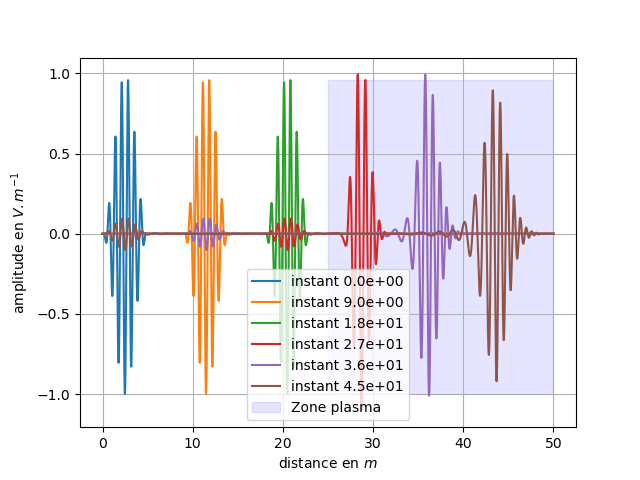

In [11]:
plt.figure()
plt.grid(True)
plt.fill_between([L/2, L], y1 = np.min(E_store[0]), y2 = np.max(E_store[0]), color = 'blue', alpha = .1, label="Zone plasma")    # pour visualiser la zone plasma
for i in range(len(E_store)) :
    plt.plot(x,E_store[i], label="instant "+str(format(time_store[i], "#.1e")))
plt.xlabel(r"distance en $m$")
plt.ylabel(r"amplitude en $V.m^{-1}$")
plt.legend()
plt.show()

Déterminer la position du paquet d'onde demande quelques réflexions : le maximum est un indicateur qualitatif, mais comme l'onde se déforme quelque peu à cause des arrondis numériques, on peut commettre une erreur de positionnement d'une demi longueur d'onde.

&nbsp;
Après plusieurs essais, on a décidé d'utiliser la moyenne des positions  pondérées par le carré de la valeur de l'onde $E(x)$ en séparant préalablement les domaines *vide* et *plasma*. On utilise pour celà la fonction `np.average(x,E)` (<a href="https://numpy.org/doc/stable/reference/generated/numpy.average.html">doc.</a>).

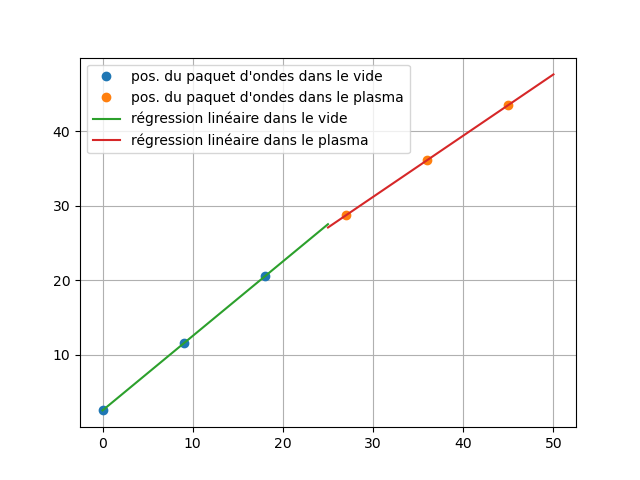

La célérité calculée dans le vide est :  1.000e+00 m/s
La célérité calculée dans le plasma est :  8.222e-01 m/s


In [12]:
pos_vide=[]
pos_plasma=[]

for i in range(len(E_store)):
    if i < 3 :
        pos_vide.append(np.average(x[:Num_x//2],weights=(E_store[i][:Num_x//2])**2))
    else : 
        pos_plasma.append(np.average(x[Num_x//2:],weights=(E_store[i][Num_x//2:])**2))

a_vide,b_vide=np.polyfit(time_store[:3],pos_vide,1)
a_plasma, b_plasma=np.polyfit(time_store[3:],pos_plasma,1)
    
plt.figure()
plt.plot(time_store[:3], pos_vide,'o', label="pos. du paquet d'ondes dans le vide")
plt.plot(time_store[3:], pos_plasma,'o', label="pos. du paquet d'ondes dans le plasma")
plt.plot(t[:Num_t//2],a_vide*t[:Num_t//2]+b_vide, label="régression linéaire dans le vide")
plt.plot(t[Num_t//2:],a_plasma*t[Num_t//2:]+b_plasma, label="régression linéaire dans le plasma")
plt.legend()
plt.grid(True)
plt.show()

print("La célérité calculée dans le vide est : ",format(a_vide,"#.3e"),"m/s")
print("La célérité calculée dans le plasma est : ",format(a_plasma,"#.3e"),"m/s")

On donne ci-dessous les résultats de plusieurs essais réalisés avec les données par défaut de ce notebook pour toutes les autres variables.

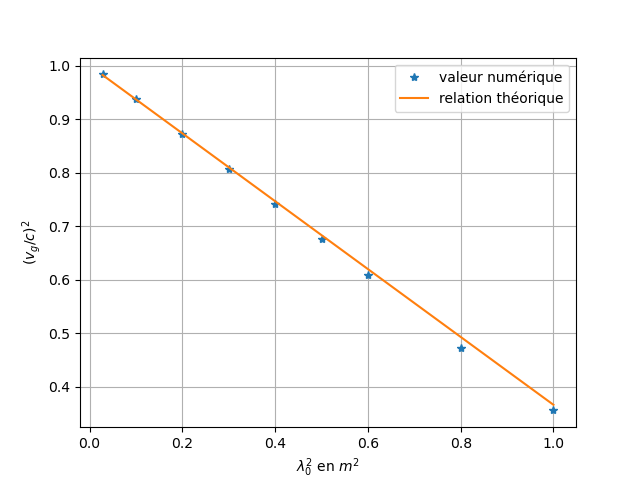

In [13]:
lambda_vide_num=np.array([lambda0,lambda0/1.118, lambda0/1.291,lambda0/1.414,lambda0/1.581,lambda0/1.826, lambda0/2.236,lambda0/3.162,lambda0/6])
c_plasma_num=np.array([5.969e-01, 6.882e-01, 7.805e-01, 8.222e-01,8.615e-01, 8.987e-01,9.341e-01,9.679e-01, 9.917e-01])

plt.figure()
plt.plot(lambda_vide_num**2, c_plasma_num**2/(c**2),'*', label='valeur numérique')
plt.plot(lambda_vide_num**2,1-((omega_p/(2*np.pi*c))**2)*lambda_vide_num**2, label='relation théorique')
plt.xlabel(r"$\lambda_0^2$ en $m^2$")
plt.ylabel(r"$(v_g/c)^2$")
plt.legend()
plt.grid(True)
plt.show()

On note un léger écart à la relation théorique à mesure de l'augmentation de la longueur d'onde, c'est-à-dire lorsque l'on se rapproche de la valeur limite de propagation dans le plasma :
$$\lambda_{0,\text{ max}}=\dfrac{2\pi c}{\omega_p}$$

La résolution numérique temporelle n'est peut-être pas suffisante pour traiter ces longueurs d'onde. À ce jour, le test qui consiste à diminuer à nouveau le pas de temps `dt` n'a pas été réalisé.

### Rôle de filtre passe-haut du plasma
Pour visualiser le rôle de filtre du plasma, on crée une forme d'onde contenant deux longueurs d'onde distinctes de part et d'autre de la pulsation plasma.

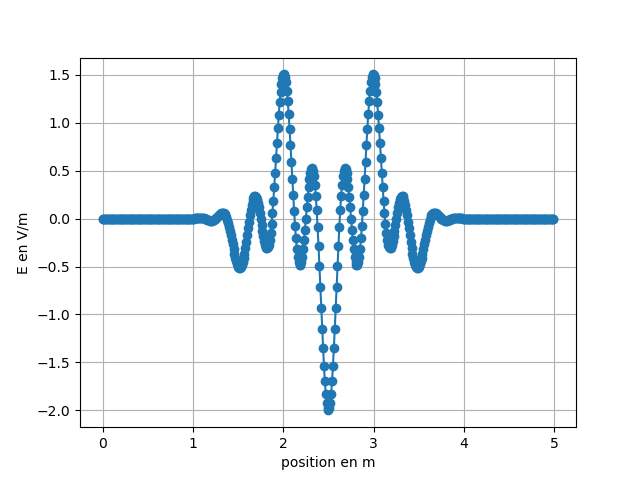

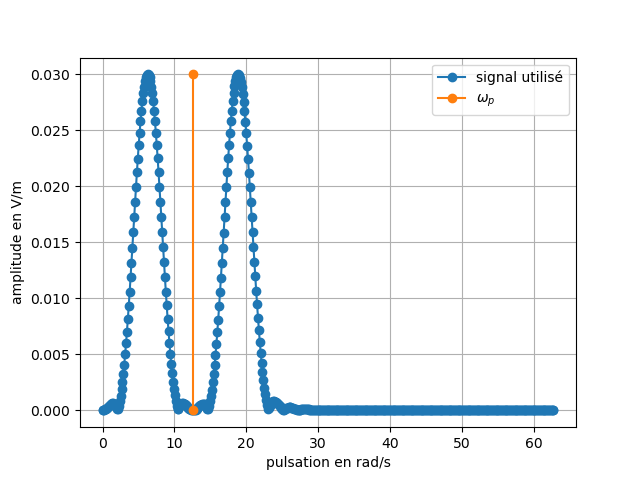

In [14]:
#####################################################################
### PASSAGE D'UN PAQUET D'ONDE DU VIDE AU PLASMA / RÔLE DE FILTRE ###
#####################################################################

# Intégration temporelle, replacée ici pour pouvoir modifier à loisir Num_t sans conséquences pour la suite
Num_t = 20001 # points de calcul
t=np.linspace(0,L/(c),Num_t) # vecteur temps
delta_t = t[1]-t[0] # intervalle temporel d'intégration

## Forme d'onde à l'instant t, t-dt et t+dt
H=3*lambda0
x0=L/20
lambda_vide = lambda0
omega_p = 12.56

E = E_amp*Hann(x,x0,H)*(np.cos(2*np.pi*x/lambda_vide)+np.cos(2*np.pi*x*3/lambda_vide)) # on élargit la fenêtre de Hann pour cette partie
E_old  = E_amp*Hann(x,x0-c*delta_t,H)*(np.cos(2*np.pi*(x+c*delta_t)/lambda_vide)+np.cos(2*np.pi*(x+c*delta_t)*3/lambda_vide))
E_new  = E_amp*Hann(x,x0+c*delta_t,H)*(np.cos(2*np.pi*(x-c*delta_t)/lambda_vide)+np.cos(2*np.pi*(x-c*delta_t)*3/lambda_vide))

# Tracé de la forme d'onde
plt.figure()
plt.plot(x[:Num_x//10],E[:Num_x//10],'-o')
plt.xlabel("position en m")
plt.ylabel("E en V/m")
plt.grid(True)
plt.show()

# Spectre du signal calculé sur 500/9=55,55 périodes
y = np.fft.rfft(E/(len(E)//2+1))
omeg = np.array([i*c*2*np.pi/np.max(x) for i in range(len(y))])


plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(omeg[:int(Num_x//10)],np.abs(y)[:int(Num_x//10)],'-o', label='signal utilisé')
plt.plot([omega_p, omega_p],[0,np.max(np.abs(y))],'-o',label=r"$\omega_p$")
plt.xlabel("pulsation en rad/s")
plt.ylabel('amplitude en V/m')
plt.legend()
plt.grid(True)
plt.show()

On s'intéresse ensuite à la propagation de cette onde vers le milieu plasma, en réutilisant le code précédent.

&nbsp;
On rajoute deux capteurs en $L/10$ et $6L/10$ pour mesurer l'évolution de la forme d'onde au cours du temps dans le vide et dans le plasma. La durée de la simulation est légèrement raccourcie de façon à éviter d'enregistrer les ondes retour.

In [15]:
E_store=[] # liste dans laquelle on stocke quelques formes d'onde intermédiaires
time_store=[] # liste dans laquelle on stocke les instants d'intérêt
capteur_vide = []
capteur_plasma = []

d2Ex=np.zeros(Num_x)

def milieu(x,xlim):
    result=np.zeros(len(x))
    for i in range(len(x)):
        if x[i]>xlim :
            result[i]=1.
    return result

def source(E):
    return -(omega_p**2)*E

duree = 40
k, time = 0,0.
while time < duree : 
    capteur_plasma.append(E[Num_x//2+Num_x//10])
    capteur_vide.append(E[Num_x//10])
    for i in range(Num_x-1):
        if i==0 :
            d2Ex[i] = (E[i+1]+0-2*E[i])/delta_x**2
        elif i==1 or i==Num_x-2 :
            d2Ex[i] = (E[i+1]+E[i-1]-2*E[i])/delta_x**2
        elif i==Num_x-1:
            d2Ex[i] = (0+E[i-1]-2*E[i])/delta_x**2
        else :
            d2Ex[i] = (-1/12*E[i+2]+4/3*E[i+1]-5/2*E[i]+4/3*E[i-1]-1/12*E[i-2])/delta_x**2
    E_new = 2*E - E_old + ((c*delta_t)**2)*d2Ex + milieu(x,L/2)*source(E)*delta_t**2
    E_old, E = E, E_new
    if k%(duree/(5*delta_t)) == 0 :
        E_store.append(E)
        time_store.append(time)
    k += 1
    time += delta_t

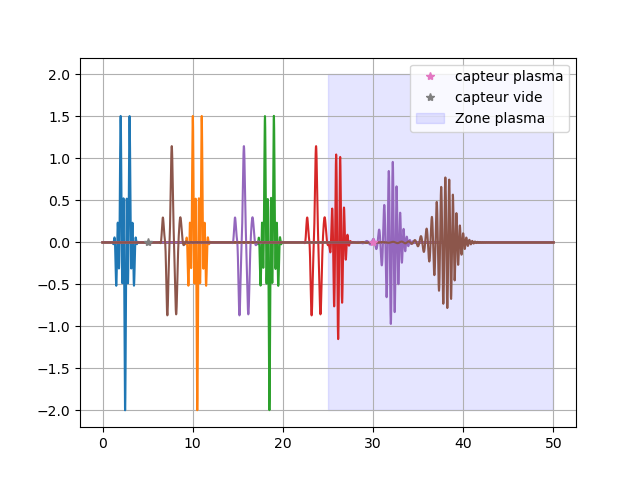

In [16]:
plt.figure()
plt.grid(True)
plt.fill_between([L/2, L], y1 = -2, y2 = 2, color = 'blue', alpha = .1, label="Zone plasma")    # pour visualiser la zone plasma
for Ei in E_store :
    plt.plot(x,Ei)
plt.plot(x[Num_x//2+Num_x//10],0, '*', label="capteur plasma")
plt.plot(x[Num_x//10],0, '*', label="capteur vide")
plt.legend()
plt.show()

On remarque sur le graphique ci-dessus qu'une partie des ondes incidentes se sont réfléchies sur le plasma. Qualitativement, les grandes longueurs d'onde ont été réfléchies, les plus faibles ont pu traverses.

&nbsp;
Les données enregistrées par le capteur peuvent alors être traitées avec un transformée de Fourier discrète pour en extraire le spectre.

&nbsp;
On peut alors comparer les fréquences de l'onde intiale, qui s'est propagée dans le vide, et celle de l'onde qui a réussi à pénétrer dans le plasma.

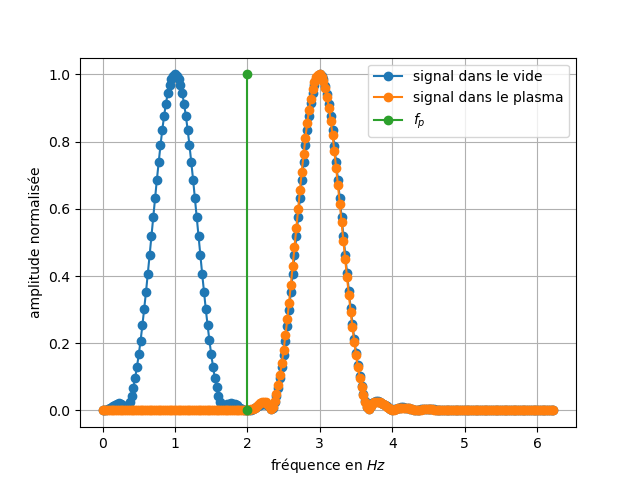

In [17]:
### Spectre du signal mesuré

## Spectre temporel
y_vide = np.fft.rfft(np.array(capteur_vide)/(len(capteur_vide)//2+1))
y_plasma = np.fft.rfft(np.array(capteur_plasma)/(len(capteur_plasma)//2+1))
freq = np.array([i/duree for i in range(len(y))])

plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(freq[:int(Num_x//20)],np.abs(y_vide)[:int(Num_x//20)]/np.max(np.abs(y_vide)),'-o', label='signal dans le vide')
plt.plot(freq[:int(Num_x//20)],np.abs(y_plasma)[:int(Num_x//20)]/np.max(np.abs(y_plasma)),'-o', label='signal dans le plasma')
plt.plot([omega_p/(2*np.pi), omega_p/(2*np.pi)],[0,1],'-o',label=r"$f_p$")
plt.legend()
plt.xlabel(r"fréquence en $Hz$")
plt.ylabel('amplitude normalisée')
plt.grid(True)
plt.show()

Les résultats sont sans équivoques, le plasma joue donc bien un rôle de *filtre passe-haut*.